### 물류의 최적화 경로
: 물류의 최적 경로를 컨설팅하는 테크닉 10

당신은 어떤 기업의 창고에 있습니다. 
1) 그 창고에는 1만 개의 상품 재고가 보관되어 있습니다. 
2) 상품은 전국 대리점에서 판매됩니다. 
3) 이 기업은 이 창고뿐만 아니라 전국에 창고가 흩어져 있습니다. 
4) 더 복잡한 것은 전국 여러 공장에서 생산된 상품이 각각의 창고에 도착한다는 사실입니다.             
> 이렇게 전국으로 상품을 판매하는 기업에게 어디에서 어느 정도의 상품을 생산하고 어느 창고에 재고를 보관하고 어느 대리점에 몇 개의 상품을 배송하는가 하는 '물류'(물건의 흐름 제어)는 상품의 매출을 좌우하는 생명선이라고 할 수 있습니다.

'물류'의 개념은 대리점뿐 아니라 많은 업계에 응용할 수 있습니다. 
1. 보험 회사라면 영업 사원이 어떤 경로로 영업해야 하는지
2. 택시 회사라면 어떤 경로에 각각의 택시를 배차할 것인가의 계획에 이용할 수 있습니다. 

이 장에서는 '물류'의 기초가 되는 '운송최적화'를 검토하고 기초적인 기술을 배웁니다. 
> 실제 물류 데이터로부터 <b><u>네트워크 구조를 가시화하는 방법을 배우고 최적 물류 계획을 세우</b></u>는 흐름을 배웁니다.

고객의 소리) 우리 회사는 제품의 제조에서 물류까지 도맡아 하고 있습니다. 최근 회사 이익이 감소하고 있어 <b><u>물류비용을 줄이고 효율화</b></u>를 생각하고 있습니다. 먼저 제품의 부품을 보관하는 창고에서 생산 공장까지 운송 비용을 낮출 수 있을지 분석을 부탁드립니다.

[전제조건]             
북부 지사와 남부 지사의 데이터를 시스템에서 추출해 CSV로 제공합니다.      
                          
집계 기간) 2019년 1월 1일 ~ 2019년 12월 31일             
                    
tbl_factory.csv : 생산 공장 데이터            
tbl_warehouse.csv : 창고 데이터            
rel_cost.csv : 창고와 공장 간의 운송 비용              
tbl_transaction.csv : 2019년의 공장으로의 부품 운송 실적        

#### 1. 데이터 불러오기

* 각 FCID, WHID, RCostID, TRID는 키

In [1]:
# 물류 데이터 불러오기
import pandas as pd

factory = pd.read_csv('./data/tbl_factory.csv', index_col= 0)
factory.head()

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,서울공장,28,북부
FC00002,수원공장,29,북부
FC00003,인천공장,31,북부
FC00004,대전공장,25,북부
FC00005,대구공장,21,남부


In [2]:
warehouse = pd.read_csv('./data/tbl_warehouse.csv', index_col= 0)
warehouse.head()

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,판교창고,35,북부
WH00002,용인창고,41,북부
WH00003,수원창고,42,북부
WH00004,대전창고,60,남부
WH00005,대구창고,72,남부


In [3]:
trans_cost = pd.read_csv('./data/rel_cost.csv', index_col= 0)
trans_cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [4]:
transaction = pd.read_csv('./data/tbl_transaction.csv', index_col= 0)
transaction.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


데이터 분석의 기초가 될 데이터는 운송 실적이므로 이를 중심으로 정보를 결합

In [5]:
total_trans_cost = trans_cost.merge(right= factory, how= 'left', on= 'FCID')
total_trans_cost.head()

total_trans_cost = total_trans_cost.merge(right= warehouse, how= 'left', on= 'WHID')
total_trans_cost.head()

total_transaction = transaction.merge(total_trans_cost, how= 'left', 
                                      left_on= ['ToFC', 'FromWH'], right_on= ['FCID', 'WHID'])

total_transaction.head()
# total_transaction = total_transaction[['TransactionDate', 'ToFC', 'FromWH', 'Quantity', 'Cost', 
#                                        'FCID', 'FCName', 'FCDemand', 'FCRegion',
#                                        'WHID', 'WHName', 'WHSupply', 'WHRegion']]

total_transaction = total_transaction[['TransactionDate','Quantity', 'Cost', 
                                       'ToFC', 'FCName', 'FCDemand', 'FCRegion',
                                       'FromWH', 'WHName', 'WHSupply', 'WHRegion']] # FCID, WHID 제외

total_transaction.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FCRegion,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,북부,WH00003,수원창고,42,북부
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,남부,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,남부,WH00004,대전창고,60,남부
3,2019-01-01 07:17:06,18,1.6,FC00002,수원공장,29,북부,WH00003,수원창고,42,북부
4,2019-01-01 07:52:18,30,0.8,FC00001,서울공장,28,북부,WH00002,용인창고,41,북부


>> 북부 지사와 남부 지사 비교

In [6]:
north = total_transaction.loc[total_transaction['WHRegion'] == '북부']
north.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FCRegion,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,대전공장,25,북부,WH00003,수원창고,42,북부
3,2019-01-01 07:17:06,18,1.6,FC00002,수원공장,29,북부,WH00003,수원창고,42,북부
4,2019-01-01 07:52:18,30,0.8,FC00001,서울공장,28,북부,WH00002,용인창고,41,북부
7,2019-01-01 09:09:30,12,1.5,FC00001,서울공장,28,북부,WH00003,수원창고,42,북부
8,2019-01-01 10:52:55,27,1.5,FC00003,인천공장,31,북부,WH00003,수원창고,42,북부


In [7]:
south = total_transaction.loc[total_transaction['WHRegion'] == '남부']
south.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FCRegion,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,부산공장,25,남부,WH00006,광주창고,65,남부
2,2019-01-01 06:32:32,31,0.9,FC00006,광주공장,30,남부,WH00004,대전창고,60,남부
5,2019-01-01 08:56:09,31,0.3,FC00005,대구공장,21,남부,WH00005,대구창고,72,남부
6,2019-01-01 09:00:15,33,0.7,FC00006,광주공장,30,남부,WH00006,광주창고,65,남부
9,2019-01-01 14:12:51,21,0.7,FC00006,광주공장,30,남부,WH00006,광주창고,65,남부


데이터 불러오기와 가공이 완료됐습니다.                     
다음 테크닉에서 실제 운송량과 비용을 확인하고 지사 간 비교를 해봅시다.

>> 현재의 운송량과 비용 확인

- 남북부 지사별 1년간 운송한 부품 수와 비용을 집계

In [8]:
print('북부 운송 비용 :', north['Cost'].sum(), '만원')
print('남부 운송 비용 :', south['Cost'].sum(), '만원')

북부 운송 비용 : 2189.3 만원
남부 운송 비용 : 2062.0 만원


In [9]:
print('북부 부품 총 운송 갯수 : ' + str(north['Quantity'].sum()) + '개')
print('남부 부품 총 운송 갯수 : ' + str(south['Quantity'].sum()) + '개')

북부 부품 총 운송 갯수 : 49146개
남부 부품 총 운송 갯수 : 50214개


In [10]:
# 부품 1개 당 운송 비용
tmp = (north['Cost'].sum() / north['Quantity'].sum()) * 10000
print('북부 부품 1개당 운송 비용 : ' + str(int(tmp)) + '원')

tmp = round((south['Cost'].sum() / south['Quantity'].sum()) * 10000, 2)
print('남부 부품 1개당 운송 비용 : ' + str(int(tmp)) + '원')

북부 부품 1개당 운송 비용 : 445원
남부 부품 1개당 운송 비용 : 410원


총 운송 비용 : 북부 > 남부              
총 운송 갯수 : 북부 < 남부              
부품 1개당 운송 비용 : 북부 > 남부(남부가 저렴)              
           
운송 비용은 창고 > 공장 간에 발생하기 때문에 단순히 운송 비용을 절감하는 것만으로도 전체 물류 비용을 억제할 수 있습니다. 그러나 성급히 결론을 내기 전에 <u>각 지사의 평균 운송 비용</u>을 계산해 봅시다.

In [11]:
print(len(total_transaction))
total_transaction.loc[total_transaction['FCRegion'] == total_transaction['WHRegion']]
# 출력 0 > 북부 창고는 북부 공장으로만, 남부 창고는 남부 공장으로만

trans_cost.head()
trans_cost_region = trans_cost.merge(factory, how= 'left', on = 'FCID')
trans_cost_region.head()

print('북부 지사 평균 운송 비용 : ' + str(trans_cost_region.loc[trans_cost_region['FCRegion'] == '북부']['Cost'].mean()) + '만원')
print('남부 지사 평균 운송 비용 : ' + str(trans_cost_region.loc[trans_cost_region['FCRegion'] == '남부']['Cost'].mean()) + '만원')

4000
북부 지사 평균 운송 비용 : 1.075만원
남부 지사 평균 운송 비용 : 1.05만원


각 지사 평균 운송 비용은 크게 차이나지 않는데 위의 부품 1개당 운송 비용이 남부가 저렴한 걸 고려해보면 남부지사 쪽이 '효율 높게' 부품을 운송하고 있다는 것을 알 수 있습니다.                    
이제 이 장의 테마인 '물류 최적 경로'를 분석하고 컨설팅해 봅시다.

>> 네트워크 가시화

최적화 문제를 푸는 라이브러리는 여러 가지가 있지만 단순히 사용 방법을 배우는 것으로는 실제 현장에서 도움이 안됩니다. 최적화 프로그램이 도출한 계획이 올바른지 그 계획을 선택할지 여부는 현장 의사결정권자의 이해 여부에 달려 있습니다. 그래서 <u>최적화 프로그램에 의해 도출된 계획을 가시화하는 프로세스</u>와 <u>몇 가지 조건을 실제로 만족하는지를 확인하는 프로세스가 중요</u>합니다.       
최적 경로를 가시화하는 방법인 네트워크 가시화를 배워봅시다.

네트워크 가시화에 유용한 라이브러리  : NetworkX

In [12]:
# !pip install networkx

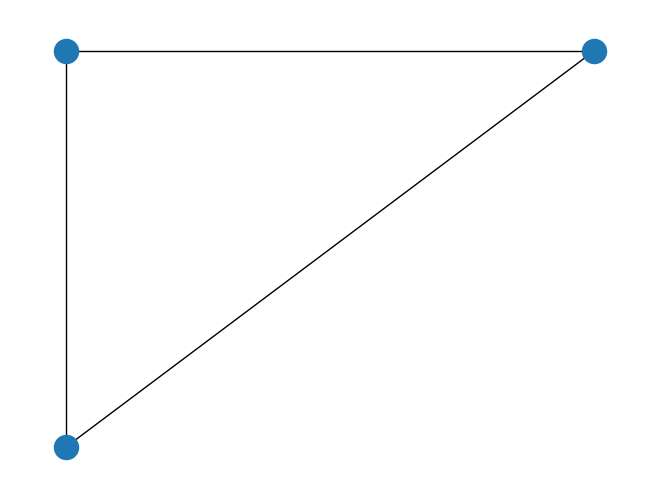

In [13]:
# 기초 프로세스
import networkx as nx 
import matplotlib.pyplot as plt

# 그래프 객체 생성
G = nx.Graph()

# 노드 설정(점)
G.add_node('nodeA')
G.add_node('nodeB')
G.add_node('nodeC')

# 엣지 설정(선)
G.add_edge('nodeA', 'nodeB')
G.add_edge('nodeA', 'nodeC')
G.add_edge('nodeB', 'nodeC')

# 좌표 설정
pos = {}
pos['nodeA'] = (0, 0)
pos['nodeB'] = (1, 1)
pos['nodeC'] = (0, 1)

# 그리기 
nx.draw(G,pos)

# 표시
plt.show()

먼저 그래프 객체를 선언하고 노드 A,B,C와 각각 연결할 엣지를 설정합니다. 다음으로 노드의 좌표를 설정하고 함수 draw를 이용해서 그립니다. 마지막으로 matplotlib의 show를 이용해서 화면에 표시합니다. 이런 흐름으로 네트워크를 가시화해서 창고에서 대리점까지의 물류를 표현할 수 있습니다. 네트워크를 가시화하면 숫자만으로 알기 어려운 물류의 쏠림과 같은 전체 그림을 파악할 수 있습니다.

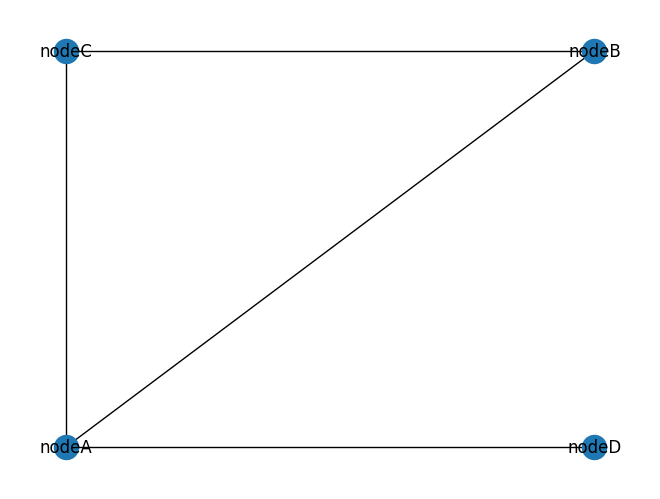

In [14]:
# 노드 추가
# 순서 : node(점), edge(선), 좌표(pos) pos = {}

G.add_node('nodeD')

G.add_edge('nodeA', 'nodeD')

pos['nodeD'] = (1, 0)

nx.draw(G, pos, with_labels= True)

>> 경로 가중치 부여

가중치를 이용해서 노드 사이 엣지 굵기를 바꾸면 최적 경로를 알기 쉽게 가시화할 수 있습니다. 여기서는 CSV 파일에 저장된 가중치 정보를 데이터프레임으로 읽어 들여 그 값을 사용하는 방법을 이용합니다.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 

In [16]:
df_weight = pd.read_csv('./data/network_weight.csv') # 비대칭 그래프(출발 방향이 달라서인지)
df_weight

df_pos = pd.read_csv('./data/network_pos.csv')
df_pos.head()


,A,B,C,D,E
0,0,0,2,2,1
1,0,2,0,2,1


(A, B) = 1.43353
(A, C) = 9.44669
(A, D) = 5.21848
(A, E) = 0.0
(B, C) = 4.5615
(B, D) = 5.68434
(B, E) = 0.0
(C, D) = 9.43748
(C, E) = 0.0
(D, E) = 6.66767


C:\Users\LGCARE\AppData\Local\Temp\ipykernel_4220\560433209.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edge_weights.append(df_w.iloc[i][j]*size)


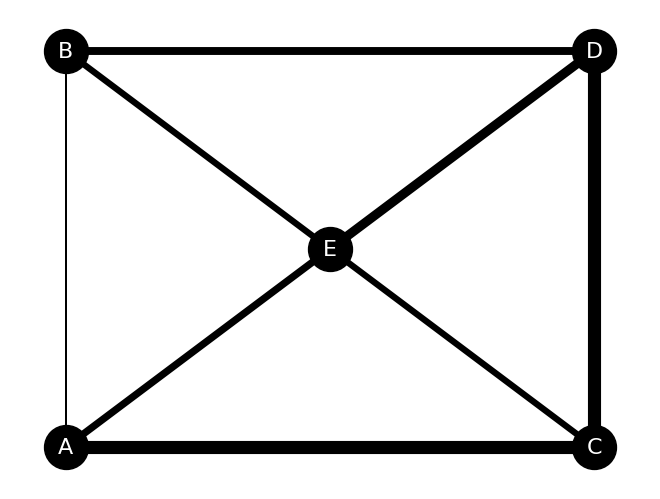

In [17]:
# 책)

# 그래프 객체 생성
G = nx.Graph()

df_w = df_weight
df_p = df_pos

# 노드 설정
for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])

# 엣지 설정 & 가중치 리스트화
size = 10
edge_weights = []
num_pre = 0
# 엣지 가중치 확인용 번역자 추가 코드
name = ['A','B','C','D','E']

for i in range(len(df_w.columns)):
    for j in range(len(df_w.columns)):
        if not (i==j):
            # 엣지 추가
            G.add_edge(df_w.columns[i],df_w.columns[j])
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                # 엣지 가중치 추가
                edge_weights.append(df_w.iloc[i][j]*size)
               
                # 엣지 가중치 확인용 번역자 추가 코드
                print(f'({name[i]}, {name[j]}) = {np.round(edge_weights[-1],5)}')
               

# 좌표 설정
pos = {}
for i in range(len(df_w.columns)):
    node = df_w.columns[i]
    pos[node] = (df_p[node][0],df_p[node][1])

# 그리기
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 표시
plt.show()

In [18]:
df_weight

,A,B,C,D,E
0,0.639921,0.143353,0.944669,0.521848,0.000000
1,0.264556,0.000000,0.456150,0.568434,0.000000
2,0.617635,0.612096,0.616934,0.943748,0.000000
3,0.000000,0.000000,0.697631,0.060225,0.666767
4,0.670638,0.210383,0.000000,0.315428,0.000000


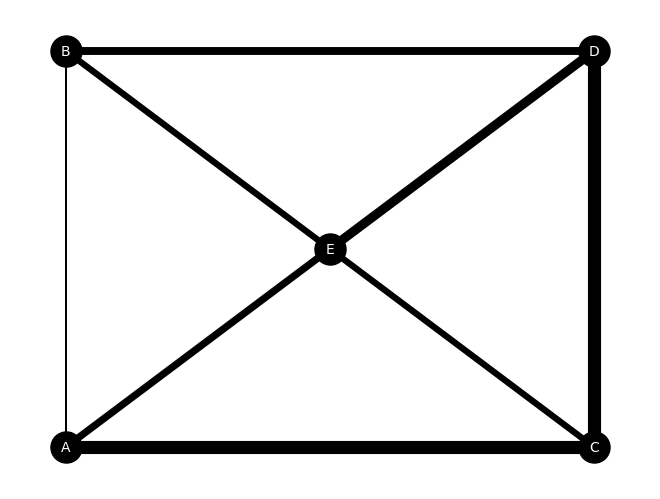

In [19]:
# 챗gpt 
# A-B, B-A 중 하나만 고려한 방법

G = nx.Graph()

# 노드 설정
for node in df_weight.columns :
  G.add_node(node)

# 엣지 설정 & 가중치 리스트
weight_list = []
for i in range(len(df_weight.columns)) :
  for j in range(i+1, len(df_weight.columns)) :
    G.add_edge(df_weight.columns[i], df_weight.columns[j])
    weight_list.append(df_weight.iloc[i, j] * 10)

# 좌표 설정
pos = {node: (df_pos[node][0], df_pos[node][1]) for node in df_weight.columns}

nx.draw(G, pos, with_labels= True, font_size= 10, font_color= 'w', node_size= 500, node_color= 'k', width= weight_list)

plt.show()


>> 운송 경로 정보 불러오기

1) trans_route.csv : 운송 경로
2) trans_route_pos.csv : 창고 및 공장의 위치 정보
3) trans_cost.csv : 창고와 공장 간의 운송 비용
4) demand.csv : 공장의 제품 생산량에 대한 수요
5) supply.csv: 창고가 공급 가능한 최대 부품 수
6) trans_route_new.csv : 새로 설계한 운송 경로

어떤 제품의 부품을 저장한 창고 W1, W2, W3에서 조립 공장 F1, F2, F3, F4로 필요한 양의 부품을 운송합니다. 되도록 최소의 비용으로 운송하고 싶지만 그러기 위해서는 어떤 창고에서 어떤 공장으로 어느 정도 양을 운송해야 하는지를 검토해야 합니다.

In [20]:
df_route = pd.read_csv('./data/trans_route.csv', index_col= '공장')
print(df_route)
print()

df_pos = pd.read_csv('./data/trans_route_pos.csv')
print(df_pos)
# 어느 창고에서 어느 공장으로 어느 정도의 양을 운송했는지를 기록한 파일 trans_route
# w2에서 F3으로의 물류가 많음
# > 네트워크 가시화를 이용해 운송 경로를 가시화

    F1  F2  F3  F4
공장                
W1  15  15   0   5
W2   5   0  30   5
W3  10  15   2  15

   W1  W2  W3   F1   F2   F3   F4
0   0   0   0  4.0  4.0  4.0  4.0
1   1   2   3  0.5  1.5  2.5  3.5


>> 운송 경로 정보로 네트워크 가시화

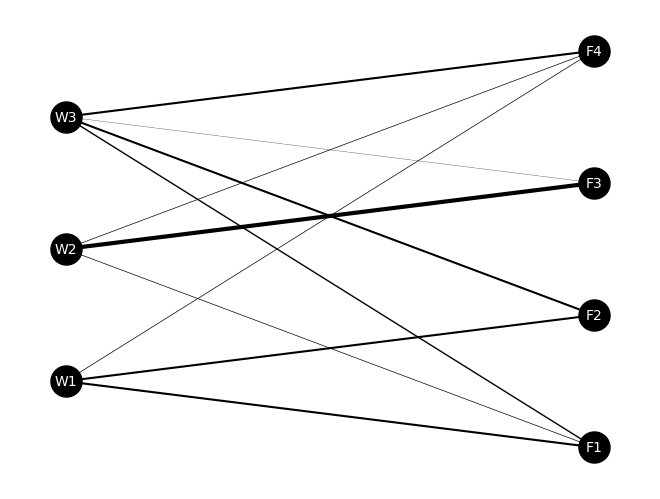

In [21]:
import networkx as nx 
import matplotlib.pyplot as plt

trans_network = nx.Graph()

# 점 생성
for i in range(len(df_pos.columns)) :
  trans_network.add_node(df_pos.columns[i])

# 엣지 생성
edge_weights= []
for warehouse in df_route.index :
  for factory in df_route.columns :
    trans_network.add_edge(warehouse, factory)
    edge_weights.append(df_route.loc[warehouse, factory] * 0.1)

# 좌표 설정
pos = {node : (df_pos[node][0], df_pos[node][1]) for node in df_pos.columns}

nx.draw(trans_network, pos, with_labels= True, width= edge_weights,
        font_size = 10, font_color= 'w', node_size= 500, node_color= 'k')

# 어느 창고에서 어느 공장으로든 골고루 엣지(운송 경로)가 존재합니다.
# 운송 비용을 생각하면 운송 경로는 어느 정도 집중되는 편이 효율이 높을 것입니다.


>> 운송 비용 함수 작성

> 운송 최적화 문제  

'최적화 문제'는 먼저 최소화(또는 최대화)하고 싶은 것을 함수로 정의합니다. 이를 '목적함수'라고 합니다.          
다음으로 최소화(또는 최대화)를 함에 있어 지켜야 할 조건을 정의합니다. 이것을 '제약 조건'이라고 합니다.        
생각할 수 있는 <u>여러 가지 운송 경로의 조합 중에서 제약 조건을 만족시키면서 목적함수를 최소화(또는 최대화)하는 조합</u>을 선택하는 것이 최적화 문제의 큰 흐름입니다.

현 가설 : '운송 비용을 낮출 효율적인 운송 경로가 존재한다.'            
목적함수 : 운송 비용 계산 함수         

In [22]:
# 운송 최적화 문제
df_route = pd.read_csv('./data/trans_route.csv', index_col= '공장')
df_route

df_cost = pd.read_csv('./data/trans_cost.csv', index_col= '공장')
df_cost.head()


,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [23]:
# 1) iloc
def total_trans_cost(route : pd.DataFrame, cost : pd.DataFrame) :
  trans_cost = 0
  for i in range(len(route)) :
    for j in range(len(route.columns)) :
      trans_cost += route.iloc[i, j] * cost.iloc[i, j]
  return trans_cost

total_trans_cost(df_route, df_cost)

# 2) loc
def total_trans_cost(route : pd.DataFrame, cost : pd.DataFrame) :
  trans_cost = 0
  for i in route.index :
    for j in route.columns :
      trans_cost += route.loc[i, j] * cost.loc[i, j]
  return trans_cost

total_trans_cost(df_route, df_cost)

# 어떤 운송 경로의 운송량과 비용을 곱하고 전부 더해서 계산
# 현재 총 운송 비용 : 1493만 원

np.int64(1493)

>> 운송 비용 함수 최적화를 위한 제약 조건 생성

각 창고는 공급 가능한 부품 수에 제한이 있고 각 공장은 채워야 할 최소한의 제품 제조량이 있습니다.
            
supply.csv : 공급 / demand.csv : 수요

- Factory로의 운송량 vs 수요량 : 운송량이 Factory의 수요량을 만족하고 있는지
             
- Warehouse로부터의 운송량 vs 공급량 : 운송량이 Warehouse의 공급량(공급한계)을 넘어서진 않는지


In [24]:
df_route = pd.read_csv('./data/trans_route.csv', index_col= '공장')
print(df_route)
print()

supply = pd.read_csv('./data/supply.csv')
print(supply)
print()

demand = pd.read_csv('./data/demand.csv')
print(demand)


    F1  F2  F3  F4
공장                
W1  15  15   0   5
W2   5   0  30   5
W3  10  15   2  15

   W1  W2  W3
0  35  41  42

   F1  F2  F3  F4
0  28  29  31  25


In [25]:
# 수요 제약 조건

# Factory로의 운송량 vs 수요량 : 운송량이 Factory의 수요량을 만족하고 있는지
def demand_check(trans_df, demand) :
  for i in range(len(demand.columns)) :
    tmp_demand = trans_df[trans_df.columns[i]].sum()
    print(f'{trans_df.columns[i]}로의 운송량 : {tmp_demand} / 수요량 : {demand.loc[0, trans_df.columns[i]]}')
    if int(tmp_demand) >= int(demand.loc[0, trans_df.columns[i]]) :
      print('수요량 만족')
    else :
      print('수요량 불만족 : 운송 경로 재계산 필요')


demand_check(df_route, demand)
print()

# Warehouse로부터의 운송량 vs 공급량(공급한계) : 운송량이 Warehouse의 공급량(공급한계)을 넘어서진 않는지
def supply_check(trans_df : pd.DataFrame, supply : pd.DataFrame) :
  for i in range(len(supply.columns)) :
    warehouse_nm = supply.columns[i]
    print(f'{warehouse_nm}로부터의 운송량 : {trans_df.loc[warehouse_nm, :].sum()} / 공급한계 : {supply.loc[0, warehouse_nm]}')
    if trans_df.loc[warehouse_nm, :].sum() <= supply.loc[0, warehouse_nm] :
      print('공급 한계 범위 내 공급')
    else :
      print('공급 한계 넘어섬 : 운송 경로 재계산 필요')

supply_check(df_route, supply)

# > 각 공장으로 운반되는 부품의 수와 각 공장에 대한 수요량을 비교하면 
# 공장에서 제조된 제품의 수가 수요량을 만족시키는지 여부를 검토할 수 있으며 이것이 그대로 제약 조건이 됩니다.
# 마찬가지로, 각 창고에서 출하되는 부품의 수와 각 창고의 공급 한계량을 비교하면
# 창고에서 공장으로 출하되는 부품의 수가 창고의 공급 한계를 넘는지를 검토할 수 있습니다.
# if문으로 현재 운송 경로가 제약 조건을 만족시키는지 알 수 있습니다.
# 이 제약 조건을 만들어두면 운송 경로를 변경했을 때 새로운 경로가 제약 조건을 만족하는지 확인할 수 있습니다.

F1로의 운송량 : 30 / 수요량 : 28
수요량 만족
F2로의 운송량 : 30 / 수요량 : 29
수요량 만족
F3로의 운송량 : 32 / 수요량 : 31
수요량 만족
F4로의 운송량 : 25 / 수요량 : 25
수요량 만족

W1로부터의 운송량 : 35 / 공급한계 : 35
공급 한계 범위 내 공급
W2로부터의 운송량 : 40 / 공급한계 : 41
공급 한계 범위 내 공급
W3로부터의 운송량 : 42 / 공급한계 : 42
공급 한계 범위 내 공급


>> 운송 경로 변경으로 인한 운송 비용 함수의 변화 확인

운송 경로 가시화를 하면 개선할 수 있을 것 같은 느낌이 들지만 많은 제약 조건을 만족하면서 목적 함수를 개선하기는 쉽지 않습니다.         
하지만 목적함수와 제약 조건을 미리 정의해두면 체계적으로 개선할 수 있습니다.

In [26]:
# 운송 경로 변경 Test)
# - W1 > F4 운송량 줄이고
# - 그만큼을 W2 > F4로의 운송량 보충

# trans_route_new.csv : 변경된 운송 경로 csv
# 1) 해당 경로가 제약 조건을 만족시키는지
# 2) 비용 개선이 어느 정도 가능한지

print(df_route)
print()

trans_route_new = pd.read_csv('./data/trans_route_new.csv', index_col= '공장')
print(trans_route_new)
print()

print('이전 운송 경로 총 비용 :', total_trans_cost(df_route, df_cost))
print('변경된 운송 경로의 총 비용 : ', total_trans_cost(trans_route_new, df_cost))
print()

supply_check(trans_route_new, supply)
demand_check(trans_route_new, demand)

    F1  F2  F3  F4
공장                
W1  15  15   0   5
W2   5   0  30   5
W3  10  15   2  15

    F1  F2  F3  F4
공장                
W1  15  15   0   0
W2   5   0  30  10
W3  10  15   2  15

이전 운송 경로 총 비용 : 1493
변경된 운송 경로의 총 비용 :  1428

W1로부터의 운송량 : 30 / 공급한계 : 35
공급 한계 범위 내 공급
W2로부터의 운송량 : 45 / 공급한계 : 41
공급 한계 넘어섬 : 운송 경로 재계산 필요
W3로부터의 운송량 : 42 / 공급한계 : 42
공급 한계 범위 내 공급
F1로의 운송량 : 30 / 수요량 : 28
수요량 만족
F2로의 운송량 : 30 / 수요량 : 29
수요량 만족
F3로의 운송량 : 32 / 수요량 : 31
수요량 만족
F4로의 운송량 : 25 / 수요량 : 25
수요량 만족


In [27]:
flag = np.zeros(len(demand.columns))
flag

array([0., 0., 0., 0.])

In [28]:
# 제약 조건 계산 함수

# 1) 수요
def condition_demand(trans_route_df : pd.DataFrame, demand_df : pd.DataFrame) :
  flag = np.zeros(len(demand_df.columns))
  for i in range(len(demand_df.columns)) :
    factory_nm = demand_df.columns[i]
    trans_quantity = trans_route_df[factory_nm].sum()
    if trans_quantity >= demand_df.loc[0, factory_nm] :
      flag[i] = 1 # 범위 내
  return flag

res_demand = condition_demand(trans_route_new, demand)
print('수요 조건 계산 결과 : ' + str(res_demand) + '  cf) 1 : 수요 충족 / 0 : 수요량 미충족')

# 2) 공급
def condition_supply(trans_route_df : pd.DataFrame, supply_df : pd.DataFrame) :
  flag = np.zeros(len(supply.columns))
  for i in range(len(supply.columns)) :
    warehouse_nm = supply.columns[i]
    supply_quantity = trans_route_df.loc[warehouse_nm, :].sum()
    if supply_quantity <= supply.loc[0, warehouse_nm] :
      flag[i] = 1 # 범위 내 
  return flag

res_supply = condition_supply(trans_route_new, supply)
print('공급 조건 계산 결과 : ' + str(res_supply) + '  cf) 1: 공급 한계 내 / 0 : 공급 한계 초과')


수요 조건 계산 결과 : [1. 1. 1. 1.]  cf) 1 : 수요 충족 / 0 : 수요량 미충족
공급 조건 계산 결과 : [1. 0. 1.]  cf) 1: 공급 한계 내 / 0 : 공급 한계 초과


trans_route_new는 W1에서 F4로의 운송을 줄이고 그만큼을 W2에서 F4로의 운송을 보충하는 것입니다.             
이것에 의해 운송 비용은 1428(만 원)으로 원래 운송 비용 1493(만 원)과 비교하면 약간의 비용 절감을 기대할 수 있습니다.          
그렇지만 공급 조건을 만족시키지 못해 W2의 공급 한계를 넘어버린 것을 알 수 있습니다.

> 지금까지 네트워크 가시화에 대해 배우고 최적의 물류 계획을 세우기 위한 흐름을 배웠습니다.         
다음 장에서는 라이브러리를 사용해 최적 계산 방법을 배우고 물류 네트워크 전체의 최적화를 검토합니다.

### 물류 네트워크 최적 설계

"당신이 가지고 있는 데이터 분석 기술을 이용해서 우리 회사의 경영 환경을 개선해주세요." 라는 의뢰를 받으면 당신은 먼저 필요한 데이터를 수집하고 그것을 가시화할 것입니다.         
대리점이라면 1년간의 매출 상황을 가시화하고 잘 팔리는 것과 그렇지 않은 것에 대한 원인 분석을 할 것입니다. 그리고 최적화 계산으로 매출을 올리기 위한 방법을 검토할 것입니다.              
            
그렇지만 '물류 네트워크'가 포함된 경영 전반 업무가 되면 문제가 갑자기 복잡해집니다. 앞장에서 배운 네트워크 가시화나 운송 최적화 검토만으로는 충분하지 않습니다. 개별 최적화뿐 아니라 <u>물류 네트워크 전체의 최적화</u>가 필요합니다.         
                
몇 개의 라이브러리를 이용해 최적화 계산을 진행한 후 앞장에서의 네트워크 가시화 기술로 계산 결과의 타당성을 확인하는 방법을 배웁니다.

고객의 소리) 우리 회사의 제조에서 물류까지의 전체 흐름 중 <u>어디에 비용 개선 가능성이 있는지</u> 분석해 주셨으면 합니다.

전제 조건)           
제품을 판매하는 대리접(P, Q)         
판매되는 상품군 (제품 A, B)           
예측된 일정 수요        
공장 X, Y           
생산 라인 (레인 0, 1)                  


In [29]:
!pip install pulp


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\LGCARE\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [30]:
!pip install ortoolpy


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\LGCARE\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# pulp : 최적화 모델 작성
# ortoolpy : 목적함수를 생성해 최적화 문제를 푸는 역할

import numpy as np 
import pandas as pd 
from itertools import product 
from pulp import LpVariable, lpSum, value 
from ortoolpy import model_min, addvars, addvals

# LP : Linear Programming(선형 계획법)
# 1) 변수 정의 
# x1 = pulp.LpVariable('x1', lowBound= 0) 

# 2) 모델 정의
# model = pulp.LpProblem('test_lp', pulp.LpMinimize)

# 3) 목적 함수 정의(6x1 + 4x2 + 2x3)
# model += 6*x1 + 4*x2 + 2*x3

# 4) 제약 조건
# model += 4 * x1 + 2 * x2 + x3 >= 5 ,,

# 5) 풀기
# model.solve()

# 6) 최적값/최적해
# pulp.value(model.objective)
# x1.varValue


# 변수 여러개
# idxlist = [i + 1 for i in range(n)]
# x = pulp.LpVariable.dicts('x', idxlist, lowBound=0)
# x[1] + x[3] + x[7] >= 6 - 사용 방법


# lpSum([o[j] * x[j] for j in idxlist]) <=> sigma j부터 n까지 cj * xj


In [32]:
df_transcost = pd.read_csv('./data/trans_cost.csv', index_col= '공장')
df_demand = pd.read_csv('./data/demand.csv')
df_supply = pd.read_csv('./data/supply.csv')

print(df_transcost) # 운송 비용
print()
print(df_demand)
print()
print(df_supply)


    F1  F2  F3  F4
공장                
W1  10  10  11  27
W2  18  21  12  14
W3  15  12  14  12

   F1  F2  F3  F4
0  28  29  31  25

   W1  W2  W3
0  35  41  42


In [ ]:
# 최적화 함수 실습
np.random.seed(1)

num_warehouse = len(df_transcost.index)
num_factory = len(df_transcost.columns)
# matrix_coordinate = [(i,j) for i in range(num_warehouse) for j in range(num_factory)]
# print(matrix_coordinate)
matrix_coordinate = list(product(range(num_warehouse), range(num_factory)))
# print(matrix_coordinate)

# 모델 설정
opt_min_model = model_min()

# 변수 정의 - x(i,j)의 운송량
xi_j = {(i,j) : LpVariable('x%d_%d'%(i,j), lowBound=0) for i,j in matrix_coordinate}

# 목적 함수 정의
opt_min_model += lpSum(df_transcost.iloc[i][j] * xi_j[i,j] for i, j in matrix_coordinate)

# 제약 함수 정의
# 1) 공급 한계
for i in range(num_warehouse) :
  opt_min_model += lpSum(xi_j[i,j] for j in range(num_factory)) <= df_supply.iloc[0][i]

# 2) 수요
for j in range(num_factory) :
  opt_min_model += lpSum(xi_j[i,j] for i in range(num_warehouse)) >= df_demand.iloc[0][j]

# 변수 xi_j가 최적화
opt_min_model.solve()

C:\Users\LGCARE\AppData\Local\Temp\ipykernel_4220\895076405.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  opt_min_model += lpSum(df_transcost.iloc[i][j] * xi_j[i,j] for i, j in matrix_coordinate)
C:\Users\LGCARE\AppData\Local\Temp\ipykernel_4220\895076405.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  opt_min_model += lpSum(xi_j[i,j] for j in range(num_factory)) <= df_supply.iloc[0][i]
C:\Users\LGCARE\AppData\Local\Temp\ipykernel_4220\895076405.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

1

In [ ]:
# 최적해의 총 운송 비용 계산

df_opt_trans_quantity = df_transcost.copy()
total_cost = 0
for key, x in xi_j.items() : # k : (0,0), x : v0_0
  i, j = key[0], key[1]
  df_opt_trans_quantity.iloc[i][j] = value(x) # v0_0의 최적값
  total_cost += (df_transcost.iloc[i][j]) * value(x)

print('총 운송 비용 : ' + str(total_cost))
# 1296만원으로 기존 1433만원과 비교할 때 비용이 크게 절감됨

총 운송 비용 : 1296.0


C:\Users\LGCARE\AppData\Local\Temp\ipykernel_4220\1388332618.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_opt_trans_quantity.iloc[i][j] = value(x) # v0_0의 최적값
C:\Users\LGCARE\AppData\Local\Temp\ipykernel_4220\1388332618.py:7: Futur

### 최적 운송 경로 네트워크 가시화

In [ ]:
# 책)

# 초기 설정
np.random.seed(1)

num_warehouse = len(df_transcost.index)
num_factory = len(df_transcost.columns)
pr = list(product(range(num_warehouse), range(num_factory))) # list(행, 열) > 행 : warehouse(0~2), 열 : factory(0~3)
# pr : [(0, 0), (0, 1), ,,,(2, 3)]

# 수리 모델 작성
# 최소화를 실행하는 모델 'model_1'
# 정의된 목적함수를 제약 조건 하에서 '최소화'할 수 있습니다.
model_1 = model_min()

# 변수 정의
# 변수 vi,j : 운송량 > 최적해 : 최적의 운송량
# v1 : {(0, 0) : v0_0, (0, 1) : v0_1, ,,, (2, 3) : v2_3} > 변수 총 6개(vi,j)
v1 = {(i, j) : LpVariable('v%d_%d'%(i,j), lowBound= 0) for i, j in pr} 

# 목적 함수 정의
# 각 운송 경로의 비용 * 변수 vi,j(운송량) - 각 요소의 곱의 합
model_1 += lpSum(df_transcost.iloc[i][j] * v1[(i, j)] for i, j in pr) 

# 제약 조건 추가
# i=0일때 창고0으로부터 공장j까지의 총 운송량이 창고0의 공급한계를 넘어선 안됨
for i in range(num_warehouse) :
  model_1 += lpSum(v1[i,j] for j in range(num_factory)) <= df_supply.iloc[0][i] # 공장이 제조할 제품 수요량 만족하는 제약 조건

# j=0일때 창고i로부터 공장0까지의 총 운송량이 공장0의 수요를 넘어야 함
for j in range(num_factory) :
  model_1 += lpSum(v1[i, j] for i in range(num_warehouse)) >= df_demand.iloc[0][j] # 창고가 제공할 부품이 제공 한계를 넘지 않는 제약 조건

# 주어진 조건 하 목적 함수 해결 > v1이 최적화되고 최적의 총 운송 비용이 구해짐
model_1.solve() 
